In [161]:
import requests
from bs4 import BeautifulSoup
import json
import time
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
%matplotlib notebook

In [162]:
hist_headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36',
           'referer':"https://www.nseindia.com/products/content/equities/equities/eq_security.htm" } 
today_headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

In [163]:
def get_stock_today(symbol):
    link = "https://www.nseindia.com/live_market/dynaContent/live_watch/get_quote/GetQuote.jsp"
    payload = {"symbol":symbol.upper(), "illiquid":0, "smeFlag":0, "itpFlag" : 0}
    r = requests.get(link,params = payload, headers=today_headers)
    soup=BeautifulSoup(r.content,"lxml")
    resdic = json.loads(str(soup.find("div",{"id":"responseDiv"}).contents[0].strip()))
    ltp = float(resdic["data"][0]["lastPrice"].replace(",",""))
    day_open = float(resdic["data"][0]["open"].replace(",",""))
    day_high = float(resdic["data"][0]["dayHigh"].replace(",",""))
    day_low = float(resdic["data"][0]["dayLow"].replace(",",""))
    low_52 = float(resdic["data"][0]["low52"].replace(",",""))
    high_52 = float(resdic["data"][0]["high52"].replace(",",""))
    pclose = float(resdic["data"][0]["previousClose"].replace(",",""))
    vwap = float(resdic["data"][0]["averagePrice"].replace(",",""))
    bq1 = 0 if resdic["data"][0]["buyQuantity1"] == "-" else int(resdic["data"][0]["buyQuantity1"].replace(",",""))
    bq2 = 0 if resdic["data"][0]["buyQuantity2"] == "-" else int(resdic["data"][0]["buyQuantity2"].replace(",",""))
    bq3 = 0 if resdic["data"][0]["buyQuantity3"] == "-" else int(resdic["data"][0]["buyQuantity3"].replace(",",""))
    bq4 = 0 if resdic["data"][0]["buyQuantity4"] == "-" else int(resdic["data"][0]["buyQuantity4"].replace(",",""))
    bq5 = 0 if resdic["data"][0]["buyQuantity5"] == "-" else int(resdic["data"][0]["buyQuantity5"].replace(",",""))
    bq = [bq1, bq2, bq3, bq4, bq5]
    sq1 = 0 if resdic["data"][0]["sellQuantity1"] == "-" else int(resdic["data"][0]["sellQuantity1"].replace(",",""))
    sq2 = 0 if resdic["data"][0]["sellQuantity2"] == "-" else int(resdic["data"][0]["sellQuantity2"].replace(",",""))
    sq3 = 0 if resdic["data"][0]["sellQuantity3"] == "-" else int(resdic["data"][0]["sellQuantity3"].replace(",",""))
    sq4 = 0 if resdic["data"][0]["sellQuantity4"] == "-" else int(resdic["data"][0]["sellQuantity4"].replace(",",""))
    sq5 = 0 if resdic["data"][0]["sellQuantity5"] == "-" else int(resdic["data"][0]["sellQuantity5"].replace(",",""))
    sq = [sq1, sq2, sq3, sq4, sq5]
    bp1 = 0 if resdic["data"][0]["buyPrice1"] == "-" else float(resdic["data"][0]["buyPrice1"].replace(",",""))
    bp2 = 0 if resdic["data"][0]["buyPrice2"] == "-" else float(resdic["data"][0]["buyPrice2"].replace(",",""))
    bp3 = 0 if resdic["data"][0]["buyPrice3"] == "-" else float(resdic["data"][0]["buyPrice3"].replace(",",""))
    bp4 = 0 if resdic["data"][0]["buyPrice4"] == "-" else float(resdic["data"][0]["buyPrice4"].replace(",",""))
    bp5 = 0 if resdic["data"][0]["buyPrice5"] == "-" else float(resdic["data"][0]["buyPrice5"].replace(",",""))
    bp = np.array([bp1, bp2, bp3, bp4, bp5])
    sp1 = 0 if resdic["data"][0]["sellPrice1"] == "-" else float(resdic["data"][0]["sellPrice1"].replace(",",""))
    sp2 = 0 if resdic["data"][0]["sellPrice2"] == "-" else float(resdic["data"][0]["sellPrice2"].replace(",",""))
    sp3 = 0 if resdic["data"][0]["sellPrice3"] == "-" else float(resdic["data"][0]["sellPrice3"].replace(",",""))
    sp4 = 0 if resdic["data"][0]["sellPrice4"] == "-" else float(resdic["data"][0]["sellPrice4"].replace(",",""))
    sp5 = 0 if resdic["data"][0]["sellPrice5"] == "-" else float(resdic["data"][0]["sellPrice5"].replace(",",""))
    sp = np.array([sp1, sp2, sp3, sp4, sp5])
    updatetime = pd.to_datetime(resdic["lastUpdateTime"])
    retrieve_time = pd.to_datetime(time.strftime("%Y-%m-%d %H:%M:%S"))
    name = resdic["data"][0]["companyName"]
    tdic = {
        "TIME":retrieve_time,"STOCK":symbol.upper(),"LTP":ltp,
        "OPEN":day_open,"HIGH":day_high,"LOW":day_low,
        "VWAP":vwap,"NAME":name,
        "LOW52":low_52,"HIGH52":high_52,"PCLOSE":pclose,
        "OQ1":sq1,"OQ2":sq2,"OQ3":sq3,"OQ4":sq4,"OQ5":sq5,
        "OP1":sp1,"OP2":sp2,"OP3":sp3,"OP4":sp4,"OP5":sp5,
        "BP1":bp1,"BP2":bp2,"BP3":bp3,"BP4":bp4,"BP5":bp5,
        "BQ1":bq1,"BQ2":bq2,"BQ3":bq3,"BQ4":bq4,"BQ5":bq5,
    }
    #print(resdic)
    return(tdic)

In [164]:
def get_symbol_count(symbol):
    symbol = symbol.upper()
    sym_count = "https://www.nseindia.com/marketinfo/sym_map/symbolCount.jsp"
    sym_count_pl = {"symbol":symbol}
    sym_count_request = requests.get(sym_count, params = sym_count_pl)
    symbol_count  = int(sym_count_request.content.strip())
    return symbol_count

In [165]:
def calc_rsi(prices,periods):
    prices = np.array(prices)
    changes = np.array(pd.Series(prices).diff())
    RSI_VECTOR = []
    for o in range(periods):
        RSI_VECTOR.append(np.NaN)
    for j in np.arange(1,prices.size-periods+1,1):
        ADV = []
        DEC = []
        for i in np.arange(j,j+periods,1):
            if changes[i] > 0:
                ADV.append( changes[i] )
            else:
                DEC.append(abs(changes[i]))         
        mean_ADV = sum(ADV)/periods
        mean_DEC = sum(DEC)/periods
        RS = mean_ADV / mean_DEC
        RSI = 100 - (100/(1 + RS))
        RSI_VECTOR.append(RSI)
    rsi = np.array(RSI_VECTOR)
    return(rsi)

In [166]:
def get_3_month(symbol):
    symbol = symbol.upper()
    link = "https://www.nseindia.com/products/dynaContent/common/productsSymbolMapping.jsp"
    payload = { "symbol":symbol,"segmentLink":3,"symbolCount":get_symbol_count(symbol),
            "series":"EQ","dateRange":"3month",
            "fromDate":"","toDate":"","dataType":"PRICEVOLUME"}
    with requests.Session() as s:
        r = s.get(link, params = payload, headers=hist_headers)
    today_status = get_stock_today(symbol)
    data = pd.read_html(r.content, header=0)[0]
    colnames = {
                'Symbol':"sym", 'Series':"ser", 'Date':"date", 
                'Prev Close':"pc", 'Open Price':"o", 'High Price':"h",
                'Low Price':"l", 'Last Price':"ltp", 'Close Price':"c", 
                'Average Price':"ap",'Total Traded Quantity':"totalqty", 
                'Turnover':"turnover",'No. of Trades':"trades", 
                'Deliverable Qty':"delqty",'% Dly Qt to Traded Qty':"delbytotal"
               }
    data.rename(columns = colnames, inplace = True)
    da = dt.strptime(str(today_status["TIME"]).split(" ")[0], '%Y-%m-%d').date()
    today = pd.DataFrame({"date":[da],
                          "o": [today_status["OPEN"]], 
                          "h":[today_status["HIGH"]], 
                          "l":[today_status["LOW"]], 
                          "c":[today_status["LTP"]]})
    data = pd.concat([data, today], sort = True)
    data['sma5'] = data.c.rolling( window = 5).mean()
    data['sma8'] = data.c.rolling( window = 8).mean()
    data['change'] = data.c.diff()
    data["date"] = pd.to_datetime(data.date)
    data = data.sort_values(by = ["date"])
    data = data.set_index(pd.DatetimeIndex(data["date"]))
    data['sma5'] = data.c.rolling( window = 5).mean()
    data['sma8'] = data.c.rolling( window = 8).mean()
    data['change'] = data.c.diff()
    data['ema12'] = data.c.ewm(span=12, min_periods = 12, adjust=True).mean()
    data['ema26'] = data.c.ewm(span=26, min_periods = 26, adjust=True).mean()
    data['macd']  = data['ema12'] - data['ema26']
    data['sig'] = data['macd'].ewm(span=9, min_periods = 9, adjust=True).mean()
    data['bars']  = data['macd']-data['sig']
    data['rsi'] = calc_rsi(data.c,14)
    return data

In [167]:
def plot_ohlc(symbol):
    df = get_3_month(symbol)
    today_status = get_stock_today(symbol)
    df['date'] = df.index.map(mdates.date2num)
    ohlc = df[['date','o','h','l','c']]
    #print(ohlc)
    f1, ax = plt.subplots(figsize = (10,5))
    # plot the candlesticks
    candlestick_ohlc(ax, ohlc.values, width=.5, colorup='green', colordown='red')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.axhline(y=today_status["LTP"], color="black", lw=0.5)
    ax.annotate("LTP : "+str(today_status["LTP"]),  # Your string
            # The point that we'll place the text in relation to 
            xy=(0.025, 0), 
            # Interpret the x as axes coords, and the y as figure coords
            xycoords=('axes fraction', 'figure fraction'),
            # The distance from the point that the text will be at
            xytext=(0, 300),  
            # Interpret `xytext` as an offset in points...
            textcoords='offset points')
    ax.annotate("O : "+str(today_status["OPEN"]),  # Your string
            # The point that we'll place the text in relation to 
            xy=(0.025, 0), 
            # Interpret the x as axes coords, and the y as figure coords
            xycoords=('axes fraction', 'figure fraction'),
            # The distance from the point that the text will be at
            xytext=(80, 300),  
            # Interpret `xytext` as an offset in points...
            textcoords='offset points')
    ax.annotate("H : "+str(today_status["HIGH"]),  # Your string
            # The point that we'll place the text in relation to 
            xy=(0.025, 0), 
            # Interpret the x as axes coords, and the y as figure coords
            xycoords=('axes fraction', 'figure fraction'),
            # The distance from the point that the text will be at
            xytext=(160, 300),  
            # Interpret `xytext` as an offset in points...
            textcoords='offset points')
    ax.annotate("L : "+str(today_status["LOW"]),  # Your string
            # The point that we'll place the text in relation to 
            xy=(0.025, 0), 
            # Interpret the x as axes coords, and the y as figure coords
            xycoords=('axes fraction', 'figure fraction'),
            # The distance from the point that the text will be at
            xytext=(240, 300),  
            # Interpret `xytext` as an offset in points...
            textcoords='offset points')
    ax.annotate("PrevC: "+str(today_status["PCLOSE"]),  # Your string
            # The point that we'll place the text in relation to 
            xy=(0.025, 0), 
            # Interpret the x as axes coords, and the y as figure coords
            xycoords=('axes fraction', 'figure fraction'),
            # The distance from the point that the text will be at
            xytext=(0, 285),  
            # Interpret `xytext` as an offset in points...
            textcoords='offset points')
    plt.title(today_status["NAME"])
    plt.show()

<IPython.core.display.Javascript object>


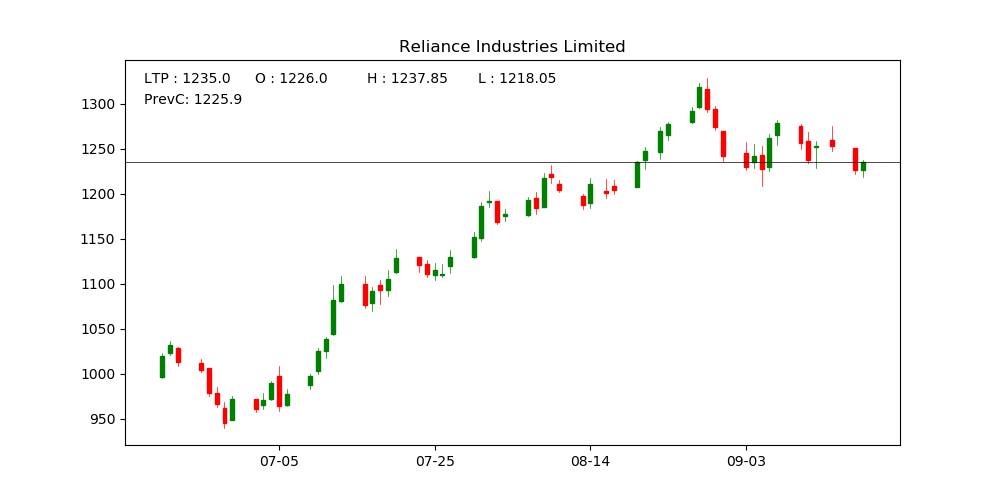

In [168]:
plot_ohlc("RELIANCE")

In [ ]:
def scrape_nse(symbol, seconds, filename):
    records = []
    rec = get_stock_data(symbol)
    df  = pd.DataFrame([rec],columns=rec.keys())
    df.to_csv(filename)
    with open(filename, 'a') as f:
        for i in range(seconds):
            rec = get_stock_data(symbol)
            record = pd.DataFrame([rec],columns=rec.keys())
            record.to_csv(f, header=False)
            records.append(record)
            time.sleep(1)
    df = pd.concat(records)
    return(df)

In [ ]:
scrape_nse("rcom",15,"rcom_1.csv")

In [82]:
today_status = get_stock_today("RELIANCE")

In [83]:
today_status

{'TIME': Timestamp('2018-09-18 11:06:34'),
 'STOCK': 'RELIANCE',
 'LTP': 1228.65,
 'OPEN': 1226.0,
 'HIGH': 1235.45,
 'LOW': 1218.05,
 'VWAP': 1229.31,
 'NAME': 'Reliance Industries Limited',
 'LOW52': 779.1,
 'HIGH52': 1329.0,
 'PCLOSE': 1225.9,
 'OQ1': 47,
 'OQ2': 84,
 'OQ3': 503,
 'OQ4': 402,
 'OQ5': 1299,
 'OP1': 1228.75,
 'OP2': 1228.8,
 'OP3': 1228.85,
 'OP4': 1228.9,
 'OP5': 1228.95,
 'BP1': 1228.25,
 'BP2': 1228.15,
 'BP3': 1228.1,
 'BP4': 1228.05,
 'BP5': 1228.0,
 'BQ1': 8,
 'BQ2': 21,
 'BQ3': 8,
 'BQ4': 959,
 'BQ5': 1121}

In [84]:
da = dt.strptime(str(today_status["TIME"]).split(" ")[0], '%Y-%m-%d').date().toordinal()
today = pd.DataFrame({"date":[da],"o": [today_status["OPEN"]], "h":[today_status["HIGH"]], "l":[today_status["LOW"]], "c":[today_status["LTP"]]})

In [85]:
today

,date,o,h,l,c
0,736955,1226.0,1235.45,1218.05,1228.65


In [70]:
da

736955